## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, text!, colgap!, rowgap!,
linkyaxes!, linkxaxes!, hidedecorations!, GridLayout, density!, hidexdecorations!, hideydecorations!, 
colsize!, rowsize!, Relative, Label, Top
import Makie: available_gradients, pseudolog10
import Measures: mm
import StatsBase: sample, mean, min, mode, max, std
using Distributed
import DataFrames: DataFrame, names
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial
import Calculus: derivative
import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
import HypothesisTests: SignedRankTest, OneSampleTTest, UnequalVarianceTTest, TwoSampleTTest
using ProgressMeter
import Plots: palette
c=palette(:default); c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    #fontsize =20,
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    ))

In [2]:
nanlength(x) = length(x[.~isnan.(x)])
nanse(x) = nanstd(x)/sqrt(nanlength(x));

# Load raw data; find error rates and RTs

In [3]:
file_path = "./SI_data_2armed_bandit_intermixed trials/"
file_load = "choices_gain"; df_choices_g = DataFrame(File(file_path*file_load*".csv"));
file_load = "choices_loss"; df_choices_l = DataFrame(File(file_path*file_load*".csv"));
file_load = "rt_gain";      df_rtg       = DataFrame(File(file_path*file_load*".csv"));
file_load = "rt_loss";      df_rtl       = DataFrame(File(file_path*file_load*".csv"));
file_load = nothing; file_path = nothing;

nparticipants = length(names(df_choices_g));
ids = 1:nparticipants;

mat_chg = Float64.(Matrix(df_choices_g[:, :]));
mat_chl = Float64.(Matrix(df_choices_l[:, :]));
mat_rtg = Float64.(Matrix(df_rtg[:, :]));
mat_rtl = Float64.(Matrix(df_rtl[:, :]));

println(minimum(mat_rtg), minimum(mat_rtl), maximum(mat_rtg), maximum(mat_rtl))

## remove trials with RTs less than 50 ms (possible due to technical issues)
time_threshold = 50 * 10^(-3); #Miliseconds
println(findall(mat_rtg .≤ time_threshold)); println(findall(mat_rtl .≤ time_threshold))
mat_chg[mat_rtg .≤ time_threshold] .= NaN; mat_chl[mat_rtl .≤ time_threshold] .= NaN;
mat_rtg[mat_rtg .≤ time_threshold] .= NaN; mat_rtl[mat_rtl .≤ time_threshold] .= NaN;

## show trials with RTs more than 5 seconds in each condition
time_threshold_max = 5; #seconds
println((sum(mat_rtg .≥ time_threshold_max), findall(mat_rtg .≥ time_threshold_max))); println((sum(mat_rtl .≥ time_threshold_max), findall(mat_rtl .≥ time_threshold_max)))

## correct, wrong RTs
mat_rtgc = deepcopy(mat_rtg);
mat_rtgw = deepcopy(mat_rtg);
mat_rtlc = deepcopy(mat_rtl);
mat_rtlw = deepcopy(mat_rtl);
mat_rtgc[mat_chg .!= 1] .= NaN;
mat_rtgw[mat_chg .!= 0] .= NaN;
mat_rtlc[mat_chl .!= 1] .= NaN;
mat_rtlw[mat_chl .!= 0] .= NaN;

mat_choices = [mat_chg, mat_chl];
mat_rts     = [mat_rtg, mat_rtl];
mat_rtsc    = [mat_rtgc, mat_rtlc];
mat_rtsw    = [mat_rtgw, mat_rtlw];

0.198310.214658.62417.7843
CartesianIndex{2}[]
CartesianIndex{2}[]
(1, CartesianIndex{2}[CartesianIndex(23, 7)])
(6, CartesianIndex{2}[CartesianIndex(17, 3), CartesianIndex(48, 3), CartesianIndex(54, 6), CartesianIndex(1, 8), CartesianIndex(49, 17), CartesianIndex(9, 20)])


# Learning; Data processing: tab. S4

In [4]:
## 60 trials per participant, analysis from the 34th trial
start60 = 34; end60 = 60; 
trials_start = ones(Int64, nparticipants)*start60;
trials_end = ones(Int64, nparticipants)*end60; 

In [5]:
## we want to remove those participants who did not explore both options
## we remove those who did not choose both options at least once in all 60 trials

errorg   = fill(NaN, nparticipants);
errorl   = fill(NaN, nparticipants);
start = 1; tr_end = end60;
for ind in ids
    errorg[ind]  = nanmean(1 .- mat_chg[start:tr_end, ind]);
    errorl[ind]  = nanmean(1 .- mat_chl[start:tr_end, ind]);
end

## find ids of participants who did not explore both options
err_max = 1;
println((findall(x-> x == err_max, errorg), findall(x-> x == err_max, errorl)))
err_min = 0;
println((findall(x-> x == err_min, errorg), findall(x-> x == err_min, errorl)))

mean(errorg), mean(errorl), errorg[1]

([17], Int64[])
([9, 13], Int64[])


(0.16, 0.29333333333333333, 0.6666666666666666)

In [6]:
errorg   = fill(NaN, nparticipants);
errorl   = fill(NaN, nparticipants);
rtratgl  = fill(NaN, nparticipants);
rtratgcw = fill(NaN, nparticipants);
rtratlcw = fill(NaN, nparticipants);
rtg      = fill(NaN, nparticipants);
rtl      = fill(NaN, nparticipants);

for ind in ids
    start  = trials_start[ind];
    tr_end = trials_end[ind];

    errorg[ind]  = nanmean(1 .- mat_chg[start:tr_end, ind]);
    errorl[ind]  = nanmean(1 .- mat_chl[start:tr_end, ind]);

    rtg_par_fin  = nanmean(mat_rtg[start:tr_end, ind]);
    rtl_par_fin  = nanmean(mat_rtl[start:tr_end, ind]);

    rtgc_par_fin = nanmean(mat_rtgc[start:tr_end, ind]);
    rtgw_par_fin = nanmean(mat_rtgw[start:tr_end, ind]);
    rtlc_par_fin = nanmean(mat_rtlc[start:tr_end, ind]);
    rtlw_par_fin = nanmean(mat_rtlw[start:tr_end, ind]);

    #now calculate ratios per participant
    rtratgl[ind]  =  rtg_par_fin ./ rtl_par_fin;
    rtratgcw[ind] = rtgc_par_fin ./ rtgw_par_fin;
    rtratlcw[ind] = rtlc_par_fin ./ rtlw_par_fin;
    rtg[ind]      = rtg_par_fin;
    rtl[ind]      = rtl_par_fin;
end
println((findall(x-> x ≥ err_max, errorg), findall(x-> x ≥ err_max, errorl)))

err_max = 1;
mask_nan = (errorg .≥ err_max) .| (errorl .≥ err_max); # = 1 if failed; remove those who chose the wrong option after learning
mask_nan[[17, 9, 13]] .= 1;  #remove those who did not explore at all: error = 0 or 1 in all trials 1-60
ids_failed = findall(x-> x != 0, mask_nan);
println((sum(mask_nan), ids_failed, mask_nan))

errorg[mask_nan]   .= NaN;
rtg[mask_nan]      .= NaN;
rtratgcw[mask_nan] .= NaN;
rtratgl[mask_nan]  .= NaN;
errorl[mask_nan]   .= NaN;
rtl[mask_nan]      .= NaN;
rtratlcw[mask_nan] .= NaN;

digits_print = 3; 
    erg_size      = nanlength(errorg);
    erl_size      = nanlength(errorl);
    rartgl_size   = nanlength(rtratgl);
    rtratgcw_size = nanlength(rtratgcw);
    rtratlcw_size = nanlength(rtratlcw);
    rtg_size      = nanlength(rtg);
    rtl_size      = nanlength(rtl);

    erg_mean      = round(nanmean(errorg),   digits=digits_print);
    erl_mean      = round(nanmean(errorl),   digits=digits_print);
    rartgl_mean   = round(nanmean(rtratgl),  digits=digits_print);
    rtratgcw_mean = round(nanmean(rtratgcw), digits=digits_print);
    rtratlcw_mean = round(nanmean(rtratlcw), digits=digits_print);
    rtg_mean      = round(nanmean(rtg),      digits=digits_print);
    rtl_mean      = round(nanmean(rtl),      digits=digits_print);
    rtgrtl_mean   = round(rtg_mean ./ rtl_mean, digits=digits_print);

    erg_se      = round(nanse(errorg)  , digits=digits_print);
    erl_se      = round(nanse(errorl)  , digits=digits_print);
    rartgl_se   = round(nanse(rtratgl) , digits=digits_print);
    rtratgcw_se = round(nanse(rtratgcw), digits=digits_print);
    rtratlcw_se = round(nanse(rtratlcw), digits=digits_print);
    rtg_se      = round(nanse(rtg),      digits=digits_print);
    rtl_se      = round(nanse(rtl),      digits=digits_print);
    rtgrtl_se   = round((rtg_mean * rtl_se  + rtg_se  * rtl_mean) / rtl_mean^2, digits=digits_print);

println("""
    error_gain size   = $erg_size
    error_loss size   = $erl_size
    RTg/RTl size      = $rartgl_size
    RTc/RTw_gain size = $rtratgcw_size
    RTc/RTw_loss size = $rtratlcw_size
    RTg size          = $rtg_size
    RTl size          = $rtl_size
    
    error_gain ± SE   = $(erg_mean) ± $(erg_se)
    error_loss ± SE   = $(erl_mean) ± $(erl_se)
    <RTg/RTl> ± SE    = $(rartgl_mean) ± $(rartgl_se)
    RTc/RTw_gain ± SE = $(rtratgcw_mean) ± $(rtratgcw_se)
    RTc/RTw_loss ± SE = $(rtratlcw_mean) ± $(rtratlcw_se)
    RTg ± SE          = $(rtg_mean) ± $(rtg_se)
    RTl ± SE          = $(rtl_mean) ± $(rtl_se)
    <RTg>/<RTl> ± SE  = $(rtgrtl_mean) ± $(rtgrtl_se)
    
    $([nanlength(errorg), nanlength(errorl), nanlength(rtratgl), nanlength(rtratgcw), nanlength(rtratlcw)])
""")

round(nanstd(rtratgcw), digits=digits_print)

([1, 17], Int64[])
(4, [1, 9, 13, 17], Bool[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
    error_gain size   = 16
    error_loss size   = 16
    RTg/RTl size      = 16
    RTc/RTw_gain size = 9
    RTc/RTw_loss size = 16
    RTg size          = 16
    RTl size          = 16
    
    error_gain ± SE   = 0.088 ± 0.033
    error_loss ± SE   = 0.243 ± 0.035
    <RTg/RTl> ± SE    = 0.704 ± 0.045
    RTc/RTw_gain ± SE = 0.815 ± 0.103
    RTc/RTw_loss ± SE = 0.926 ± 0.061
    RTg ± SE          = 0.666 ± 0.065
    RTl ± SE          = 0.978 ± 0.09
    <RTg>/<RTl> ± SE  = 0.681 ± 0.129
    
    [16, 16, 16, 9, 16]



0.309

## Plot data points and histograms: fig S.14(d-e) in trials 34-60 after learning

start trial: 34
Error rate (gain): 0.088 ± 0.033
RT (gain): 0.666 ± 0.065
RTc/RTw (gain): 0.815 ± 0.103
Error rate (loss): 0.243 ± 0.035
RT (loss): 0.978 ± 0.09
RTc/RTw (loss): 0.926 ± 0.061


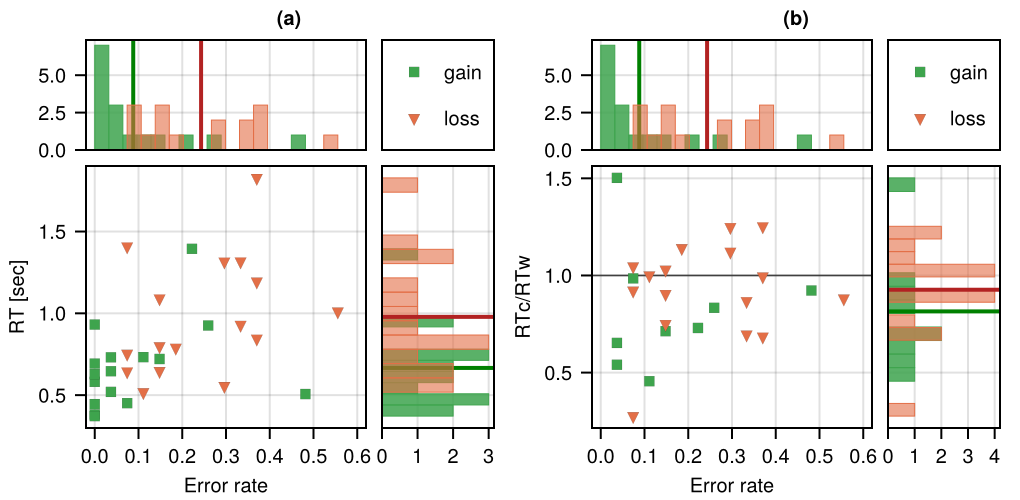

In [7]:
flag_start = 34; println("start trial: $(flag_start)")

fig = Figure(size=(510, 250), fontsize=10, figure_padding=(3, 10, 3, 3)); ax = [];  #400, 300
    ga = fig[1, 1] = GridLayout();
        axatop   = Axis(ga[1, 1], )#limits=((0, nothing), (nothing, nothing)))
        axamain  = Axis(ga[2, 1], xlabel = "Error rate", ylabel = "RT [sec]")
        axaright = Axis(ga[2, 2], )#limits=((nothing, nothing), (0, nothing)))  
        linkyaxes!(axamain, axaright);  linkxaxes!(axamain, axatop)
        xlims!(axaright, low = 0);      ylims!(axatop, low = 0); 
        hideydecorations!(axaright, grid = false); hidexdecorations!(axatop, grid = false);
        Label(ga[1, 1:2, Top()], "(a)", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
    gb = fig[1, 2] = GridLayout();
        axbtop   = Axis(gb[1, 1])
        axbmain  = Axis(gb[2, 1], xlabel="Error rate", ylabel="RTc/RTw")
        axbright = Axis(gb[2, 2])
        linkyaxes!(axbmain, axbright);   linkxaxes!(axbmain, axbtop);
        xlims!(axbright, low = 0);       ylims!(axbtop, low = 0); 
        hideydecorations!(axbright, grid = false); hidexdecorations!(axbtop, grid = false);
        Label(gb[1, 1:2, Top()], "(b)", valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
        hlines!(axbmain, [1], color=:gray25, linewidth=0.8);
markers=[:rect, :dtriangle, :diamond, :circle];
for (ind_cond, cond) in enumerate(["gain", "loss"])
    col = ind_cond + 1;
        choices = mat_choices[ind_cond];
        rts     = mat_rts[ind_cond];
        rtsc    = mat_rtsc[ind_cond];
        rtsw    = mat_rtsw[ind_cond];

        error_id  = fill(NaN, nparticipants);
        rt_id     = fill(NaN, nparticipants);
        rtcrtw_id = fill(NaN, nparticipants);

    for id in ids
        start  = flag_start == 1 ? 1 : trials_start[id];   #1; 
        tr_end = trials_end[id];

        error_id[id]  = nanmean(1 .- choices[start:tr_end, id]);
        rt_id[id]     = nanmean(rts[ start:tr_end, id]);
        rtc_id        = nanmean(rtsc[start:tr_end, id]);
        rtw_id        = nanmean(rtsw[start:tr_end, id]);
        rtcrtw_id[id] = rtc_id ./ rtw_id;
    end
    if flag_start != 1        
        error_id[ mask_nan] .= NaN;
        rt_id[    mask_nan] .= NaN;
        rtcrtw_id[mask_nan] .= NaN;
    end
    scatter!(axamain, error_id, rt_id,     markersize=8, color=c[col], marker=markers[ind_cond], strokewidth=0.05, label=cond)
    scatter!(axbmain, error_id, rtcrtw_id, markersize=8, color=c[col], marker=markers[ind_cond], strokewidth=0.05, label=cond)
    hist!(axatop,   filter(!isnan, error_id),  color=(c[col], 1.1-0.25*ind_cond), strokewidth=0.5, strokecolor=c[col], )
    hist!(axaright, filter(!isnan, rt_id),     color=(c[col], 1.1-0.25*ind_cond), strokewidth=0.5, strokecolor=c[col], direction = :x)  #, offset=0, scale_to = 1)
    hist!(axbtop,   filter(!isnan, error_id),  color=(c[col], 1.1-0.25*ind_cond), strokewidth=0.5, strokecolor=c[col], )
    hist!(axbright, filter(!isnan, rtcrtw_id), color=(c[col], 1.1-0.25*ind_cond), strokewidth=0.5, strokecolor=c[col], direction = :x)  #, offset=0, scale_to = 1)
    vlines!(axatop,   [nanmean(error_id)],     linewidth=2, color=cond=="gain" ? :green : :firebrick)
    hlines!(axaright, [nanmean(rt_id)],        linewidth=2, color=cond=="gain" ? :green : :firebrick)
    vlines!(axbtop,   [nanmean(error_id)],     linewidth=2, color=cond=="gain" ? :green : :firebrick)
    hlines!(axbright, [nanmean(rtcrtw_id)], linewidth=2, color=cond=="gain" ? :green : :firebrick)
    println("Error rate ($(cond)): $(round(nanmean(error_id),  digits=3)) ± $(round(nanse(error_id),  digits=3))")
    println("RT ($(cond)): $(        round(nanmean(rt_id),     digits=3)) ± $(round(nanse(rt_id),     digits=3))")
    println("RTc/RTw ($(cond)): $(   round(nanmean(rtcrtw_id), digits=3)) ± $(round(nanse(rtcrtw_id), digits=3))")
end
colgap!(fig.layout, 10);
    colsize!(fig.layout, 1, Relative(0.5)); colsize!(fig.layout, 2, Relative(0.5))
    colgap!(ga, 8); rowgap!(ga, 8); colgap!(gb, 8); rowgap!(gb, 8);
    lega = Legend(ga[1, 2], axamain, tellheight=true);  #, tellheight=true
    legb = Legend(gb[1, 2], axbmain, tellheight=true);  #, tellheight=true
    xlims!(axamain, (-0.02, 0.62)); axamain.xticks = 0:0.1:0.6;    xlims!(axbmain, (-0.02, 0.62)); axbmain.xticks = 0:0.1:0.6;
    xlims!(axatop , (-0.02, 0.62));  axatop.xticks = 0:0.1:0.6;    xlims!(axbtop , (-0.02, 0.62));  axbtop.xticks = 0:0.1:0.6;
#rowsize!(fig.layout, 1, Relative(0.3))
fig

## Test error rates in gain vs loss

In [8]:
## Save errors for the data analysis
error_id  = fill(NaN, nparticipants, 2);
for (ind_cond, cond) in enumerate(["gain", "loss"])
    choices = mat_choices[ind_cond];
    for id in ids
        start  = trials_start[id];   #1; 
        tr_end = trials_end[id];
        error_id[id, ind_cond] = nanmean(1 .- choices[start:tr_end, id]);
    end
    error_id[ mask_nan, ind_cond] .= NaN;
end
nanmean(error_id[:, 1]), nanmean(error_id[:, 2])

(0.08796296296296295, 0.24305555555555555)

In [9]:
SignedRankTest(filter(x -> ~isnan(x), error_id[:, 1] .- error_id[:, 2]) .- 0) ## test errors in gain vs loss

Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.166667
    95% confidence interval: (-0.2222, -0.09259)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0029

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 10.0
    rank sums:                   [10.0, 126.0]
    adjustment for ties:         84.0
    normal approximation (μ, σ): (-58.0, 19.2938)


In [10]:
UnequalVarianceTTest(filter(x -> ~isnan(x), error_id[:, 1]), filter(x -> ~isnan(x), error_id[:, 2])) ## test errors in gain vs loss

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.155093
    95% confidence interval: (-0.2547, -0.05553)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0034

Details:
    number of observations:   [16,16]
    t-statistic:              -3.181829897640533
    degrees of freedom:       29.898771830574663
    empirical standard error: 0.0487432067652644


## RT distributions and learning: SI fig. S15(a-c) using all 1-60 trials

gain: mean ± STD = 0.786 ± 0.535 ± 0
loss: mean ± STD = 1.126 ± 0.794 ± 0


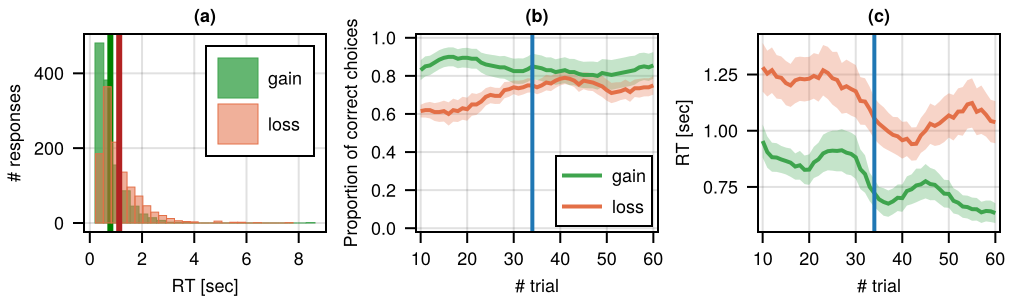

In [11]:
#flag_start_trials = 35; 
flag_start_RTdist = 1;
delta = 10;
start_trial = delta;
last_trial = 60;  #size(choices_gain, 1);
markers=[:rect, :dtriangle, :diamond, :circle];
## matriced
    errors_gain = fill(NaN, last_trial - start_trial+1);
    errors_loss = fill(NaN, last_trial - start_trial+1);
    std_gain    = fill(NaN, last_trial - start_trial+1);
    std_loss    = fill(NaN, last_trial - start_trial+1);
    rt_gain     = fill(NaN, last_trial - start_trial+1);
    rt_loss     = fill(NaN, last_trial - start_trial+1);
    rt_std_gain = fill(NaN, last_trial - start_trial+1);
    rt_std_loss = fill(NaN, last_trial - start_trial+1);
for trial in start_trial:last_trial
    errors_gain[trial-delta+1] = 1 - nanmean(nanmean(Matrix(df_choices_g[trial-delta+1:trial, :]), dims=1));
    errors_loss[trial-delta+1] = 1 - nanmean(nanmean(Matrix(df_choices_l[trial-delta+1:trial, :]), dims=1));
    std_gain[trial-delta+1] = nanse(nanmean(Matrix(df_choices_g[trial-delta+1:trial, :]), dims=1));df_rtg      
    std_loss[trial-delta+1] = nanse(nanmean(Matrix(df_choices_l[trial-delta+1:trial, :]), dims=1));df_rtl    
    rt_gain[trial-delta+1] = nanmean(nanmean(Matrix(df_rtg[trial-delta+1:trial, :]), dims=1));
    rt_loss[trial-delta+1] = nanmean(nanmean(Matrix(df_rtl[trial-delta+1:trial, :]), dims=1));
    rt_std_gain[trial-delta+1] = nanse(nanmean(Matrix(df_rtg[trial-delta+1:trial, :]), dims=1));
    rt_std_loss[trial-delta+1] = nanse(nanmean(Matrix(df_rtl[trial-delta+1:trial, :]), dims=1));  
end

fig = Figure(size=(510, 150), fontsize=9, figure_padding=(3, 10, 3, 3)); ax = []; #400, 300
push!(ax, Axis(fig[1, 2], xlabel="# trial", ylabel="Proportion of correct choices", title="(b)", yticks = 0:0.2:1, xticks = 10:10:100, limits=((delta-1, last_trial+1), (-0.02, 1.02))));
push!(ax, Axis(fig[1, 3], xlabel="# trial", ylabel="RT [sec]", title="(c)", xticks = 10:10:100, limits=((delta-1, last_trial+1), (nothing, nothing))));
push!(ax, Axis(fig[1, 1], xlabel="RT [sec]", ylabel="# responses", title="(a)"));

#hlines!(ax[1], [0.5], color=:grey45, linestyle=:dash, linewidth=1.5);
    band!( ax[1], start_trial:last_trial, 1 .- errors_gain.+std_gain, 1 .- errors_gain.-std_gain, color=(c[2], 0.3))
    band!( ax[1], start_trial:last_trial, 1 .- errors_loss.+std_loss, 1 .- errors_loss.-std_loss, color=(c[3], 0.3))
    lines!(ax[1], start_trial:last_trial, 1 .- errors_gain, color=c[2], linewidth=2, label="gain");
    lines!(ax[1], start_trial:last_trial, 1 .- errors_loss, color=c[3], linewidth=2, label="loss");
    band!( ax[2], start_trial:last_trial, rt_gain.+rt_std_gain, rt_gain.-rt_std_gain, color=(c[2], 0.3))
    band!( ax[2], start_trial:last_trial, rt_loss.+rt_std_loss, rt_loss.-rt_std_loss, color=(c[3], 0.3))
    lines!(ax[2], start_trial:last_trial, rt_gain, color=c[2], linewidth=2, label="gain");
    lines!(ax[2], start_trial:last_trial, rt_loss, color=c[3], linewidth=2, label="loss");
    
for (ind_cond, cond) in enumerate(["gain", "loss"])
    col = ind_cond + 1;
        choices = mat_choices[ind_cond];
        rts     = mat_rts[ind_cond];
        error_id  = fill(NaN, nparticipants);
        rt_id     = Array{Float64, 1}();

    for id in ids
        start  = flag_start_RTdist == 1 ? 1 : trials_start[id];   #1; 
        tr_end = trials_end[id];
        error_id[id] = nanmean(1 .- choices[start:tr_end, id]);
        append!(rt_id, filter(!isnan, rts[ start:tr_end, id]));
    end
    hist!(ax[3], rt_id, color=(c[col], 1.05-0.25*ind_cond), bins=25, strokecolor=c[col], strokewidth=0.5, label=cond);
    println("$(cond): mean ± STD = $((round(nanmean(rt_id), digits=3))) ± $((round(nanstd(rt_id), digits=3))) ± $(Int64(round(nanse(rt_id), digits=0)))")
    vlines!(ax[3], [nanmean(rt_id)], linewidth=3, color=cond=="gain" ? :green : :firebrick);
end

[vlines!(axi, [start60], color=c[1], linewidth=2) for axi in ax[1:2]]
axislegend(ax[1], position=:rb, height=38, rowgap=-4.5, margin=(0,3,3,0), padding=(3,3,0,0),);  # 
axislegend(ax[3], position=:rt);
colgap!(fig.layout, 8);
fig

# Statistical analysis: tests

## RTg/RTl != 1

In [13]:
SignedRankTest(filter(x -> ~isnan(x), rtratgl) .- 1)

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.287921
    95% confidence interval: (-0.4008, -0.1933)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-04

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 0.0
    rank sums:                   [0.0, 136.0]
    adjustment for ties:         0.0


In [14]:
OneSampleTTest(filter(x -> ~isnan(x), rtratgl) .- 1)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.296211
    95% confidence interval: (-0.3919, -0.2005)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   16
    t-statistic:              -6.599032705878055
    degrees of freedom:       15
    empirical standard error: 0.04488708313290051


## RTc/RTw in gain != 1

In [15]:
SignedRankTest(filter(x -> ~isnan(x), rtratgcw) .- 1)

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.270199
    95% confidence interval: (-0.4034, 0.07751)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0977

Details:
    number of observations:      9
    Wilcoxon rank-sum statistic: 8.0
    rank sums:                   [8.0, 37.0]
    adjustment for ties:         0.0


In [16]:
OneSampleTTest(filter(x -> ~isnan(x), rtratgcw) .- 1)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.184943
    95% confidence interval: (-0.4221, 0.05221)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1098

Details:
    number of observations:   9
    t-statistic:              -1.7983022350250635
    degrees of freedom:       8
    empirical standard error: 0.10284301633471683


## RTc/RTw in loss != 1

In [17]:
SignedRankTest(filter(x -> ~isnan(x), rtratlcw) .- 1)

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0413824
    95% confidence interval: (-0.1906, 0.06153)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.3755

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 50.0
    rank sums:                   [50.0, 86.0]
    adjustment for ties:         0.0


In [18]:
OneSampleTTest(filter(x -> ~isnan(x), rtratlcw) .- 1)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0735367
    95% confidence interval: (-0.2042, 0.05713)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.2489

Details:
    number of observations:   16
    t-statistic:              -1.19957702727145
    degrees of freedom:       15
    empirical standard error: 0.06130222048917262


## RTc/RTw in gain != RTc/RTw in loss

In [19]:
UnequalVarianceTTest(filter(x -> ~isnan(x), rtratgcw), filter(x -> ~isnan(x), rtratlcw))

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -0.111406
    95% confidence interval: (-0.3686, 0.1458)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.3681

Details:
    number of observations:   [9,16]
    t-statistic:              -0.9304979372843674
    degrees of freedom:       13.767858644028033
    empirical standard error: 0.11972739137610061


# Compare the data with DDM's prediction

In [22]:
## experimental data:
erg_mean, erg_se, erl_mean, erl_se, rartgl_mean, rartgl_se, rtratgcw_mean, rtratgcw_se, rtratlcw_mean, rtratlcw_se

(0.088, 0.033, 0.243, 0.035, 0.704, 0.045, 0.815, 0.103, 0.926, 0.061)

In [23]:
# diffusion analytical solution for RTg/RTl; see SI eq. S56
ratTgTl_ddm(errg, errl) = (1 - 2*errg)*log(1/errl - 1) / ((1 - 2*errl)*log(1/errg - 1));
erg_mean, erl_mean, ratTgTl_ddm(erg_mean, erl_mean)

(0.088, 0.243, 0.7790350034262554)

In [24]:
## find the eoor bars using the eq. S56 and error bars for the error rates
allrat_ddm = [ratTgTl_ddm(erg_mean+erg_se, erl_mean+erl_se), 
              ratTgTl_ddm(erg_mean-erg_se, erl_mean-erl_se), 
              ratTgTl_ddm(erg_mean+erg_se, erl_mean-erl_se), 
              ratTgTl_ddm(erg_mean-erg_se, erl_mean+erl_se)]  
              
round.(abs.(allrat_ddm .- ratTgTl_ddm(erg_mean, erl_mean)), digits=2)    ## take the maximal value from here = 0.11

4-element Vector{Float64}:
 0.04
 0.06
 0.1
 0.11

In [25]:
SignedRankTest(filter(x -> ~isnan(x), rtratgl) .- ratTgTl_ddm(erg_mean, erl_mean))

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0669561
    95% confidence interval: (-0.1798, 0.02771)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1439

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 39.0
    rank sums:                   [39.0, 97.0]
    adjustment for ties:         0.0


In [26]:
OneSampleTTest(filter(x -> ~isnan(x), rtratgl) .- ratTgTl_ddm(erg_mean, erl_mean))

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0752463
    95% confidence interval: (-0.1709, 0.02043)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1144

Details:
    number of observations:   16
    t-statistic:              -1.6763471324021137
    degrees of freedom:       15
    empirical standard error: 0.04488708313290051


## Compare the experimental data with the IIM in the disordered phase (see SI fig. S15(d)2)

In [29]:
## Here we take the average RTg/RTl in the IIM's disordered phase. The value obltained in another script: "SI_Fig.S15_2armed_bandit_task_intermixed_trials_IIM_fitting.ipynb"
OneSampleTTest(filter(x -> ~isnan(x), rtratgl) .- 0.76)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0562113
    95% confidence interval: (-0.1519, 0.03946)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.2296

Details:
    number of observations:   16
    t-statistic:              -1.2522829674418496
    degrees of freedom:       15
    empirical standard error: 0.04488708313290051


In [30]:
SignedRankTest(filter(x -> ~isnan(x), rtratgl) .- 0.76)

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0479211
    95% confidence interval: (-0.1608, 0.04675)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.2522

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 45.0
    rank sums:                   [45.0, 91.0]
    adjustment for ties:         0.0


## Compare the experimental data with the IIM near the tricritical point (see SI fig. S15(d)3)

In [32]:
## Here we take the average RTg/RTl in the IIM's area near the tricritical point. The value obltained in another script: "SI_Fig.S15_2armed_bandit_task_intermixed_trials_IIM_fitting.ipynb"
OneSampleTTest(filter(x -> ~isnan(x), rtratgl) .- 0.72)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0162113
    95% confidence interval: (-0.1119, 0.07946)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7230

Details:
    number of observations:   16
    t-statistic:              -0.3611580110358147
    degrees of freedom:       15
    empirical standard error: 0.04488708313290051


In [33]:
SignedRankTest(filter(x -> ~isnan(x), rtratgl) .- 0.72)

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.00792108
    95% confidence interval: (-0.1208, 0.08675)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7436

Details:
    number of observations:      16
    Wilcoxon rank-sum statistic: 61.0
    rank sums:                   [61.0, 75.0]
    adjustment for ties:         0.0
